Training Step: 19  | total loss: 0.65987 | time: 0.539s
| Adam | epoch: 010 | loss: 0.65987 - acc: 0.5831 -- iter: 064/100
Training Step: 20  | total loss: 0.66526 | time: 1.906s
| Adam | epoch: 010 | loss: 0.66526 - acc: 0.5614 | val_loss: 0.69040 - val_acc: 0.4800 -- iter: 100/100
--


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.74it/s]


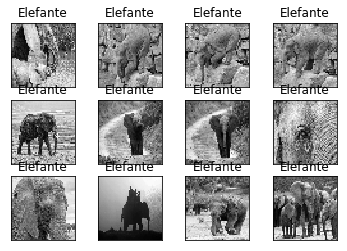

In [2]:
from sklearn import datasets, tree, model_selection
from sklearn.ensemble import RandomForestClassifier
import numpy as np #arrays
import os #diretorias
import cv2 #tratamento do tamanho da imagem)
import matplotlib.pyplot as plt #Usado para poder mostrar os animais
from random import shuffle #dados
from tqdm import tqdm #loops - barra de progresso 
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
# código tflearn- https://pythonprogramming.net/tflearn-machine-learning-tutorial/
import tensorflow as tf
tf.reset_default_graph()

image_Size=50 #pixel

learning_Rate=1e-3 #0.001 permite determinar valores com mais precisão no universo em estudo (MAX,MIN)

path_Directory_Treino="C:/animals10/Treino" #amostra de treino
path_Directory_Teste="C:/animals10/Teste"  #amostra do teste

#standardizar o modelo quanto à formatação e para 2 layers
model_Indentification="animals_Esquilo_Elefante-{}-{}.model".format(learning_Rate,"6conv-basic-video")
#"2conv-basic-video" Layers p/ 1 - linear | >=2 - não linear

#com estas funções vamos determinar a probabilidade da imagem ser Esquilo ou Galinha

#Funcao para determinar a imagem(label Esquilo ou Elefante) na path_Directory
def label_image(image):
    animal_label=image.split(".")[-3] # exemplo: Esquilo.0.jpeg
    if animal_label=="Esquilo": return[1,0]
    elif animal_label=="Elefante": return[0,1]

# Vamos determinar a precisão Accuracy pela Funcao de treino e a função de teste utilizada com base na primeira.
#Funcao de treino apenas precisa de ser executa 1 primeira vez, temos as imagens/features e a labels
#serve para determinar a precisão(accuracy)
def create_Treino():
	treino_data=[] #Iniciação lista vazia
	for image in tqdm(os.listdir(path_Directory_Treino)):
		label=label_image(image)
		path=os.path.join(path_Directory_Treino,image) #Junta o path com a imagem
		image=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(image_Size,image_Size)) # padronizar o tamanho, e ler imagens a inzento
		treino_data.append([np.array(image),np.array(label)]) # adicionar no array com o label e imagem num formato numpy
		shuffle(treino_data)
		np.save('treino_data.npy',treino_data) # salvar os dados resultante do treino
	return treino_data # retorna os dados


#Funcao de Teste ajuda a determinar a accuracy pela utilizacao dos dados de treino sem a existência de labels(imagens/numeros=id)
def execucao_Teste():
	teste_data=[]
	for image in tqdm(os.listdir(path_Directory_Teste)):
		path=os.path.join(path_Directory_Teste,image) #Junta o path com a imagem
		image_id=image.split('.')[0]
		image=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(image_Size,image_Size)) # padronizar o tamanho, e ler imagens a inzento
		teste_data.append([np.array(image),image_id]) #Associa imagem ao id
	np.save('teste_data.npy',teste_data)
	return teste_data

#Criar os dados de treino
treino_data=create_Treino()



# código tflearn
convnet = input_data(shape=[None, image_Size, image_Size, 1], name='input')# tamanho de imagem definido em image_Size

#6 layers
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax') # Esquilo ou Elefante
convnet = regression(convnet, optimizer='adam', learning_rate=learning_Rate, loss='categorical_crossentropy', name='targets')# Definido learning_Rate

#model = tflearn.DNN(convnet,tensorboard_dir='log') #windows
model = tflearn.DNN(convnet)

#carrega o existente
treino_data=np.load('treino_data.npy')
teste_data=np.load('teste_data.npy')

#Determinar a Accuracy entre os dados de treino e de teste P/ accuracy semelhante
treino=treino_data[:100] #100 exemplos de dados
teste= treino_data[-50:]

#standardizar ou seja converter em numpy array as imagens e os labels 
X=np.array([i[0] for i in treino]).reshape(-1,image_Size,image_Size,1) #i[0] posição com as imagens e dimensionamento das imagens
Y=[i[1] for i in treino]

#Testar a accuracy de X e Y anteriores
TesteX=np.array([i[0] for i in teste]).reshape(-1,image_Size,image_Size,1) #i[0] posição com as imagens e dimensionamento das imagens
TesteY=[i[1] for i in teste]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': TesteX}, {'targets': TesteY}), #n_epoch=Training step
   snapshot_step=50, show_metric=True, run_id='modeloEstudo')

#Identificar os animais
treino_data=execucao_Teste()
fig=plt.figure()
for id,dataAnimal in enumerate(treino_data[:12]):#Vou mostrar 12 animais
    image_id=dataAnimal[1]
    data_image=dataAnimal[0]
    y=fig.add_subplot(3,4,id+1)#mostra a matriz com as imagens 4x3 com incremento do id
    source_image=data_image
    dataAnimal=data_image.reshape(image_Size,image_Size,1) #padronizar o tamanho das imagens
    modelo=model.predict([dataAnimal])[0]# lista de 1 prediction

    if np.argmax(modelo)==1: label_animal="Elefante"
    else: label_animal="Esquilo"
    
    y.imshow(source_image,cmap="gray")# para a imagem mostrar em cinzento
    plt.title(label_animal)
    y.axes.get_xaxis().set_visible(False) #Não mostra o eixo do x
    y.axes.get_yaxis().set_visible(False) #Não mostra o eixo do y
plt.show()# Mostra o a imagem e os titulo
